[View in Colaboratory](https://colab.research.google.com/github/gatchaman-20140215/reversi4/blob/master/Q_Learning.ipynb)

# リバーシのゲームエンジン

In [0]:
# 定数の設定
import string

BOARD_SIZE = 4
MAX_TURN = 16

EMPTY = -1
BLACK = 0
WHITE = 1
WALL = 2
DRAW = 2

MOVE = 2
TURN = 3
COLOR = 4
MOVABLE_POS = 5

MASK_EDGE = 0x0660
MASK_VERTICAL = 0x6666
MASK_HORIZONTAL	= 0x0FF0

DIR_LEFT_OBLIQUE = 5
DIR_RIGHT_OBLIQUE = 3
DIR_HORIZONTAL = 1
DIR_VERTICAL = 4

POSITION_NS_DICT = dict([(v, w) for (v, w) in zip(
    reversed([(1 << i) for i in range(16)]),
    ['{}{}'.format(j, i) for i in list(range(1, 5)) for j in list(string.ascii_lowercase)[0:4]])])
POSITION_NS_DICT[0] = 'pass'
POSITION_SN_DICT = { v: k for k, v in POSITION_NS_DICT.items() }

In [0]:
# 盤面クラス
import copy

class Board:
    def __init__(self, position=None, current_color=BLACK, current_turn=0):
        if position is None:
            self.position = [0x0240, 0x420]
            self.current_color = BLACK
        else:
            self.position = [position[BLACK], position[WHITE]]
            self.current_color = current_color

        self.movable_pos = self.generate_legal(self.current_color)

        self.current_turn = 0 if current_turn is None else current_turn
        self.history = [None] * (MAX_TURN + 16)
        self.history[self.current_turn] = [
            self.position[BLACK],
            self.position[WHITE],
            None,
            None,
            self.current_color,
            self.movable_pos
        ]

    def move(self, point):
        if point == 0: self.skip()
        if self.movable_pos & point == 0: return False

        next_color = self.current_color ^ 1
        flipped = self.generate_some_flipped(self.position[self.current_color], self.position[next_color] & MASK_EDGE, point, DIR_LEFT_OBLIQUE)
        flipped |= self.generate_some_flipped(self.position[self.current_color], self.position[next_color] & MASK_EDGE, point, DIR_RIGHT_OBLIQUE)
        flipped |= self.generate_some_flipped(self.position[self.current_color], self.position[next_color] & MASK_VERTICAL, point, DIR_HORIZONTAL)
        flipped |= self.generate_some_flipped(self.position[self.current_color], self.position[next_color] & MASK_HORIZONTAL, point, DIR_VERTICAL)

        self.position[self.current_color] = self.position[self.current_color] | point | flipped
        self.position[next_color] = self.position[next_color] ^ flipped

        self.history[self.current_turn][MOVE] = point
        self.current_turn += 1
        self.current_color = next_color
        self.movable_pos = self.generate_legal(self.current_color)
        self.history[self.current_turn] = [
            self.position[BLACK],
            self.position[WHITE],
            None,
            self.current_turn,
            self.current_color,
            self.movable_pos
        ]

        return True

    def skip(self):
        if self.movable_pos != 0: return False
        if self.is_game_over(): return False

        self.history[self.current_turn][MOVE] = 0
        self.current_color ^= 1
        self.current_turn += 1
        self.movable_pos = self.generate_legal(self.current_color)
        self.history[self.current_turn] = [
            self.position[BLACK],
            self.position[WHITE],
            None,
            self.current_turn,
            self.current_color,
            self.movable_pos
        ]

        return True

    def undo(self):
        if self.current_turn == 0: return False

        self.history[self.current_turn] = None
        self.current_color ^= 1
        self.current_turn -= 1
        self.position[BLACK] = self.history[self.current_turn][BLACK]
        self.position[WHITE] = self.history[self.current_turn][WHITE]
        self.movable_pos = self.history[self.current_turn][MOVABLE_POS]
        self.history[self.current_turn][MOVE] = None

        return True

    def is_game_over(self):
        if self.movable_pos != 0: return False
        if self.generate_legal(self.current_color ^ 1) != 0: return False

        return True

    def winner(self):
        if not self.is_game_over(): return None

        black_num = bin(self.position[BLACK]).count('1')
        white_num = bin(self.position[WHITE]).count('1')
        if black_num > white_num:
            return BLACK
        elif black_num < white_num:
            return WHITE
        else:
            return DRAW

    def is_board_full(self):
        return (self.position[BLACK] | self.position[WHITE]) == 0xFFFF

    def show_history(self):
        for h in self.history:
            if h is None: break
            board = Board(
                position=[h[BLACK], h[WHITE]],
                current_color=h[COLOR],
                current_turn=h[TURN]
            )
            print(board.to_string())
            print('move:{}'.format(POSITION_NS_DICT[h[MOVE]] if h[MOVE] is not None else 'pass'))

    def to_string(self):
        board_str = '手番：黒\n' if self.current_color == BLACK else '手番：白\n'
        board_str += '{0:#06x}, {1:#06x}\n'.format(self.position[BLACK], self.position[WHITE])
        board_str += ' a b c d\n'

        for y in range(BOARD_SIZE):
            board_str += '{}'.format(y + 1)
            for x in range(BOARD_SIZE):
                pos = 2 ** ((BOARD_SIZE - 1 - x) + (BOARD_SIZE - 1 - y) * BOARD_SIZE)
                if (self.position[BLACK] & pos) != 0:
                    board_str += '●'
                elif (self.position[WHITE] & pos) != 0:
                    board_str += '○'
                else:
                    board_str += '　'
            board_str += '\n'

        return board_str

    def copy(self):
        board = Board()
        board.position = copy.deepcopy(self.position)
        board.current_color = self.current_color
        board.current_turn = self.current_turn
        board.movable_pos = self.movable_pos
        board.history = copy.deepcopy(self.history)

        return board

    def movable_pos_array(self):
        a = []
        movable_pos = self.movable_pos
        while movable_pos != 0:
            act = movable_pos & (-movable_pos)
            a.append(act)
            movable_pos ^= act

        return a

    def generate_legal(self, turn=None):
        if turn is None: turn = self.current_color
        return (~(self.position[BLACK] | self.position[WHITE]) & 0xFFFF) \
            & (self.generate_some_legal(self.position[turn], self.position[turn ^ 1] & MASK_EDGE, DIR_LEFT_OBLIQUE) \
             | self.generate_some_legal(self.position[turn], self.position[turn ^ 1] & MASK_EDGE, DIR_RIGHT_OBLIQUE) \
             | self.generate_some_legal(self.position[turn], self.position[turn ^ 1] & MASK_VERTICAL, DIR_HORIZONTAL) \
             | self.generate_some_legal(self.position[turn], self.position[turn ^ 1] & MASK_HORIZONTAL, DIR_VERTICAL))

    def generate_some_legal(self, own, masked_enemy, direction):
        flipped = ((own << direction) | (own >> direction)) & masked_enemy
        for _ in range(BOARD_SIZE - 2):
            flipped |= ((flipped << direction) | (flipped >> direction)) & masked_enemy
        return (flipped << direction) | (flipped >> direction)

    def generate_some_flipped(self, own, masked_enemy, move, direction):
        left_enemy = (move << direction) & masked_enemy
        right_enemy = (move >> direction) & masked_enemy
        left_own = (own << direction) & masked_enemy
        right_own = (own >> direction) & masked_enemy

        return ((left_enemy & (right_own | (right_own >> direction))) | \
            ((left_enemy << direction) & right_own) | (right_enemy & (left_own | (left_own << direction))) | \
            ((right_enemy >> direction) & left_own))

    def hashkey(self):
        min_key = (self.position[BLACK] << 16) + self.position[WHITE]

        # 水平線に対する線対称
        black = Board.rotate_horizontally(self.position[BLACK])
        white = Board.rotate_horizontally(self.position[WHITE])
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 垂直線に対する線対称
        black = Board.rotate_vertically(black)
        white = Board.rotate_vertically(white)
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 水平線に対する線対称
        black = Board.rotate_horizontally(black)
        white = Board.rotate_horizontally(white)
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 左斜線に対する線対称
        black = Board.transpose(black)
        white = Board.transpose(white)
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 左90°回転（水平線に対する線対称）
        black = Board.rotate_horizontally(black)
        white = Board.rotate_horizontally(white)
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 左90°回転（垂直線に対する線対称）
        black = Board.rotate_vertically(black)
        white = Board.rotate_vertically(white)
        key = (black << 16) + white
        if key < min_key: min_key = key
        # 左90°回転（水平線に対する線対称）
        black = Board.rotate_horizontally(black)
        white = Board.rotate_horizontally(white)
        key = (black << 16) + white
        if key < min_key: min_key = key

        return min_key
    
    def state(self):
      return (*self.position, self.current_color)

    @staticmethod
    def rotate_horizontally(position):
        position = ((position >> 4) & 0x0F0F0F0F) | ((position << 4) & 0xF0F0F0F0)
        position = ((position >> 8) & 0x00FF00FF) | ((position << 8) & 0xFF00FF00)
        return position

    @staticmethod
    def rotate_vertically(position):
        position = ((position >> 1) & 0x55555555) | ((position << 1) & 0xAAAAAAAA)
        position = ((position >> 2) & 0x33333333) | ((position << 2) & 0xCCCCCCCC)
        return position

    @staticmethod
    def transpose(position):
        position = ((position >> 4) & 0x0A0A0A0A) | ((position >> 1) & 0x05050505) \
                 | ((position << 1) & 0xA0A0A0A0) | ((position << 4) & 0x50505050)
        position = ((position >> 8) & 0x00CC00CC) | ((position >> 2) & 0x00330033) \
                 | ((position << 2) & 0xCC00CC00) | ((position << 8) & 0x33003300)
        return position

        return ret

    @staticmethod
    def rotate_position(*args):
        ret = []

        rotated_v = [0] * len(args)
        for i, v in enumerate(args):
            rotated_v[i] = Board.rotate_horizontally(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.rotate_vertically(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.rotate_horizontally(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.transpose(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.rotate_horizontally(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.rotate_vertically(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        for i, v in enumerate(rotated_v):
            rotated_v[i] = Board.rotate_horizontally(v)
        if rotated_v not in ret:
            ret.append([v for v in rotated_v])

        return ret

In [0]:
# 評価クラス
from abc import *

class Evaluator(object):
    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @classmethod
    @abstractmethod
    def uppercase(clas, name):
        raise NotImplementError()

    @abstractmethod
    def evaluate(self, board):
        raise NotImplementError()

class PerfectEvaluator(Evaluator):
    @classmethod
    def uppercase(cls, name):
        return name.upper() + ' by Impl'

    def evaluate(self, board):
        #print('current_color:{}'.format(board.current_color))
        #print('own:{0:016b}, enemy:{1:016b}'.format(board.position[0], board.position[1]))
        #print('own:{0:016b}, enemy:{1:016b}'.format(board.position[board.current_color], board.position[board.current_color ^ 1]))
        return bin(board.position[board.current_color]).count('1') - \
            bin(board.position[board.current_color ^ 1]).count('1')

In [0]:
from abc import *
import random
import math

class AI(object):
    __metaclass__ = ABCMeta

    MAX_SCORE = 99999
    MIN_SCORE = -99999

    def __init__(self):
        pass

    @classmethod
    @abstractmethod
    def uppercase(cls, name):
        raise NotImplementError()

    @abstractmethod
    def move(self, board):
        raise NotImplementError()

class RandomAI(AI):
    @classmethod
    def uppercase(cls, name):
        return name.upper() + ' by Impl'

    def __init__(self):
        pass

    def act(self, board):
        legal = board.movable_pos
        legals = list(filter(lambda p: (legal & p) != 0, POSITION_NS_DICT.keys()))
        if len(legals) != 0:
            return random.choice(legals)
        else:
            return 0

    def move(self, board):
        act = self.act(board)
        if act != 0:
            board.move(act)
        else:
            board.skip()
        return act

class NegaMaxAI(AI):
    @classmethod
    def uppercase(cls, name):
        return name.upper() + ' by Impl'

    def __init__(self, evaluator, depth_max=15):
        self.evaluator = evaluator
        self.depth_max = depth_max
        self.node_count = 0
        self.leaf_count = 0

    def act(self, board):
        legal = board.movable_pos
        if legal == 0:
            return 0

        if bin(legal).count('1') == 1:
            return legal

        score, score_max = self.MIN_SCORE, self.MIN_SCORE
        best = 0
        while legal != 0:
            act = legal & (-legal)
            board.move(act)
            score = -self.search(board, self.MIN_SCORE, self.MAX_SCORE, 0)
            board.undo()

            if score > score_max:
                score_max = score
                best = act

            #print('move:{}, eval:{}'.format(POSITION_NS_DICT[act], score))
            legal ^= act

        # print('move:{}, eval:{}'.format(POSITION_NS_DICT[best], score_max))
        # print('leaf:{}, node:{}'.format(self.leaf_count, self.node_count))
        return best

    def move(self, board):
        act = self.act(board)
        if act != 0:
            board.move(act)
        else:
            board.skip()
        return act

    def search(self, board, alpha, beta, depth):
        self.node_count += 1

        if depth >= self.depth_max or board.is_board_full():
            self.leaf_count += 1
            return self.evaluator.evaluate(board)

        legal = board.movable_pos
        if legal == 0:
            if board.is_game_over():
                self.leaf_count += 1
                return self.evaluator.evaluate(board)
            else:
                board.skip()
                score = -self.search(board, -beta, -alpha, depth + 1)
                board.undo()
                return score

        while legal != 0:
            act = legal & (-legal)
            board.move(act)
            score = -self.search(board, -beta, -alpha, depth + 1)
            board.undo()

            if score >= beta:
                return score

            if score > alpha:
                alpha = score

            legal ^= act

        return alpha

class MonteCarloAI(AI):
    @classmethod
    def uppercase(cls, name):
        return name.upper() + ' by Impl'

    def __init__(self, try_num):
        self.try_num = try_num

    def act(self, board):
        legal = board.movable_pos
        if legal == 0:
            return 0

        if bin(legal).count('1') == 1:
            return legal

        score_max = 0
        best = 0
        while legal != 0:
            act = legal & (-legal)
            board.move(act)
            win = self.playout(board)
            board.undo()
            score = win / self.try_num
            print('move:{0}, score:{1:06.4f}'.format(POSITION_NS_DICT[act], score))

            if score > score_max:
                score_max = score
                best = act
            legal ^= act

        return best

    def move(self, board):
        act = self.act(board)
        if act == 0:
            board.skip()
        else:
            board.move(act)
        return act

    def playout(self, board):
        turn = board.current_color
        players = [RandomAI(), RandomAI()]
        win = 0
        for _ in range(self.try_num):
            tmp_board = board.copy()
            while not tmp_board.is_game_over():
                players[turn].move(tmp_board)
                turn ^= 1
            diff = bin(tmp_board.position[board.current_color ^ 1]).count('1') - bin(tmp_board.position[board.current_color]).count('1')
            if diff > 0:
                win += 1

        #print('win:{}, lose:{}, draw{}'.format(win, lose, draw))
        return win

class MonteCarloTreeAI(AI):
    @classmethod
    def uppercase(cls, name):
        return name.upper() + ' by Impl'

    def __init__(self, try_num, exploration_param=math.sqrt(2), playout_threshold=10):
        self.try_num = try_num
        self.exploration_param = exploration_param
        self.playout_threshold = playout_threshold
        self.montecarlo_ai = MonteCarloAI(try_num=1)

    def act(self, board):
        legal = board.movable_pos
        if legal == 0:
            return 0

        if bin(legal).count('1') == 1:
            return legal

        node = self.create_node(legal)

        for _ in range(self.try_num):
            self.search_uct(board, node)

        score_max = -99999
        for c in node['child']:
            if c['game_num'] > score_max:
                best = c
                score_max = c['game_num']
            print('{0}, win_rate:{1:06.4f}, game_num:{2}'.format(POSITION_NS_DICT[c['point']], c['win_rate'], c['game_num']))

        return best['point']

    def move(self, board):
        act = self.act(board)
        if act == 0:
            board.skip()
        else:
            board.move(act)
        return act

    def search_uct(self, board, node):
        c = self.select_best_ucb(node)
        board.move(c['point'])
        if c['game_num'] <= self.playout_threshold :
            win = self.montecarlo_ai.playout(board)
        else:
            if c['next'] is None:
                legal = board.movable_pos
                c['next'] = self.create_node(legal)
            win = 0 if self.search_uct(board.copy(), c['next']) > 0 else 1
        board.undo()

        c['win_rate'] = (c['win_rate'] * c['game_num'] + win) / (c['game_num'] + 1)
        c['game_num'] += 1
        node['child_game_sum'] += 1
        return win

    def select_best_ucb(self, node):
        ucb_max = -999
        for c in node['child']:
            if c['game_num'] == 0:
                ucb = 10000 + random.randint(0, 0x7FFF)
            else:
                ucb = c['win_rate'] + self.exploration_param * math.sqrt(math.log(node['child_game_sum']) / c['game_num'])
            # print('ucb:{}, win_rate:{}, child_game_sum:{}, game_num:{}, C:{}'.format(
            #     ucb, c['win_rate'], node['child_game_sum'], c['game_num'], self.exploration_param))

            if ucb > ucb_max:
                ucb_max = ucb
                select = c

        return select

    def create_node(self, legal):
        if legal == 0:
            node = { 'child_game_sum': 0, 'child': [
                {
                    'point': 0,
                    'game_num': 0,
                    'win_rate': 0,
                    'next': None
                }
            ]}
        else:
            node = { 'child_game_sum': 0, 'child': [None] * bin(legal).count('1') }
            i = 0
            while legal != 0:
                point = legal & (-legal)
                node['child'][i] = {
                    'point': point,
                    'game_num': 0,
                    'win_rate': 0,
                    'next': None
                }
                legal ^= point
                i += 1

        return node

In [0]:
# Playerクラス
from abc import *

class Player(object):
    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def act(self, board, step=None):
        raise NotImplementError()
    
    @abstractmethod
    def update_Q_function(self, observation, action, reward, observation_next):
        pass

class PlayerRandom(Player):
    def __init__(self, color, name='Random'):
        self.color = color
        self.name = name
        self.win, self.lose, self.draw = 0.0, 0.0, 0.0

    def act(self, board, step=None):
        ai = RandomAI()
        return ai.move(board)
    
    def update_Q_function(self, observation, action, reward, observation_next):
        pass

class PlayerNegaMax(Player):
    def __init__(self, color, name='NegaMax', max_depth=15):
        self.color = color
        self.name = name
        self.max_depth = max_depth
        self.win, self.lose, self.draw = 0.0, 0.0, 0.0

    def act(self, board, step=None):
        evaluator = PerfectEvaluator()
        ai = NegaMaxAI(evaluator, self.max_depth)
        return ai.move(board)
    
    def update_Q_function(self, observation, action, reward, observation_next):
        pass

class PlayerMonteCarlo(Player):
    def __init__(self, color, name='MonteCarlo', try_num=1000):
        self.color = color
        self.name = name
        self.try_num = try_num
        self.win, self.lose, self.draw = 0.0, 0.0, 0.0

    def act(self, board, step=None):
        ai = MonteCarloAI(self.try_num)
        return ai.move(board)
    
    def update_Q_function(self, observation, action, reward, observation_next):
        pass

class PlayerMonteCarloTree(Player):
    def __init__(self, color, name='MonteCarloTree', try_num=1000):
        self.color = color
        self.name = name
        self.try_num = try_num
        self.win, self.lose, self.draw = 0.0, 0.0, 0.0

    def act(self, board, step=None):
        ai = MonteCarloTreeAI(self.try_num)
        return ai.move(board)
    
    def update_Q_function(self, observation, action, reward, observation_next):
        pass

class PlayerQ(Player):
    def __init__(self, color, name='Q Learning'):
        self.color = color
        self.name = name
        self.agent = Agent()
        self.win, self.lose, self.draw = 0.0, 0.0, 0.0
  
    def act(self, board, step=None):
        acts = board.movable_pos_array()
        if len(acts) == 0:
            act = 0
            board.skip()
        else:
            act = self.agent.get_action(board.state(), step)
            board.move(act)
        return act
    
    def update_Q_function(self, observation, action, reward, observation_next):
        self.agent.update_Q_function(observation, action, reward, observation_next)

# Q学習の実装

In [0]:
import numpy as np

In [0]:
# 定数の設定
GAMMA = 0.99           # 時間割引率
ETA = 0.5              # 学習係数
MAX_STEPS = 200        # 1試行のstep数
# NUM_EPISODES = 1000    # 最大試行回数
NUM_EPISODES = 30000

In [0]:
class Agent:
    def __init__(self):
        self.brain = Brain()
  
    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(observation, action, reward, observation_next)
  
    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action

In [0]:
class Brain:
    def __init__(self):
        self.q_table = {}
        self.epsilon = 1
  
    def update_Q_table(self, state, action, reward, state_next):
        '''QテーブルをQ学習により更新"'''
        qs = self.get_q(state)
        qs_next = self.get_q(state_next)
        if len(qs_next) == 0:
            qs_next = qs
        # print('qs:{}, qs_next:{}'.format(qs, qs_next))
        # Max_Q_next = max(qs_next, key=qs_next.get)
        if state[2] == BLACK:
            Max_Q_next = max(qs_next.values())
            self.q_table[state][action] = self.q_table[state][action] + \
                ETA * (reward + GAMMA * Max_Q_next - self.q_table[state][action])
        else:
            Max_Q_next = min(qs_next.values()) * -1
            q = -1 * self.q_table[state][action]
            reward *= -1
            self.q_table[state][action] = -1 * (q + ETA * (reward + GAMMA * Max_Q_next - q))
        # print('Max_Q_next:{}, state:{}, action:{}'.format(Max_Q_next, state, action))
  
    def decide_action(self, state, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する。'''
        if self.epsilon > 0.01:
            self.epsilon -= 1 / 30000
    
        if self.epsilon <= np.random.uniform(0, 1):
            qs = self.get_q(state)
            if state[2] == BLACK:
                action = max(qs, key=qs.get)
            else:
                action = min(qs, key=qs.get)
            # print('action:{}, qs:{}'.format(action, qs))
        else:
            board = Board([state[0], state[1]], state[2])
            action = np.random.choice(board.movable_pos_array())
            # print('action:{}, movable_pos:{}'.format(action, board.movable_pos_array()))
        return action
  
    def get_q(self, state):
        if self.q_table.get(state) is None:
            board = Board([state[0], state[1]], state[2])
            self.q_table[state] = dict([(act, 0) for act in board.movable_pos_array()])
        return self.q_table[state]

In [0]:
class Environment:
    '''4x4リバーシを実行する環境のクラス'''
    def __init__(self):
        self.win_rate_history = []
  
    def run(self):
        '''実行'''
        win_episodes = 0    # 勝利した試行数
        players = [
            PlayerQ(BLACK),
            PlayerRandom(WHITE),
        ]
        
        for episode in range(NUM_EPISODES):    # 試行回数分繰り返す。
            board = Board()
            turn = BLACK

            # print(board.to_string())
            while not board.is_game_over():
                state = board.state()
                action = players[turn].act(board, episode)
                # print(board.to_string())
                
                if board.is_game_over():
                    if board.winner() == BLACK:
                        reward = 1
                        players[BLACK].win += 1.0
                        players[WHITE].lose += 1.0
                    elif board.winner() == WHITE:
                        reward = -1
                        players[BLACK].lose += 1.0
                        players[WHITE].win += 1.0
                    else:
                        reward = 0
                        players[BLACK].draw += 1.0
                        players[WHITE].draw += 1.0
                else:
                    reward = 0
                
                if action != 0:
                    players[turn].update_Q_function(state, action, reward, board.state())
                    players[turn ^ 1].update_Q_function(state, action, reward, board.state())
                turn ^= 1

            # print('winner:{}'.format(board.winner()))
            # print(players[1].agent.brain.q_table)
            
            players.reverse()
        
            if (episode + 1) % 1000 == 0:
                win_rate = players[BLACK].win / (players[BLACK].win + players[BLACK].lose + players[BLACK].draw)
                print('episode:{}, win:{}, lose:{}, draw:{}, win rate:{}'.format(
                    episode + 1, players[BLACK].win, players[BLACK].lose, players[BLACK].draw, win_rate))
                players[BLACK].win, players[BLACK].lose, players[BLACK].draw = 0.0, 0.0, 0.0
                players[WHITE].win, players[WHITE].lose, players[WHITE].draw = 0.0, 0.0, 0.0
                
                self.win_rate_history.append([episode + 1, win_rate])
        
        # print(self.agent.brain.q_table)

In [11]:
# main
env = Environment()
env.run()

episode:1000, win:472.0, lose:438.0, draw:90.0, win rate:0.472
episode:2000, win:489.0, lose:393.0, draw:118.0, win rate:0.489
episode:3000, win:546.0, lose:361.0, draw:93.0, win rate:0.546
episode:4000, win:579.0, lose:341.0, draw:80.0, win rate:0.579
episode:5000, win:643.0, lose:312.0, draw:45.0, win rate:0.643
episode:6000, win:649.0, lose:316.0, draw:35.0, win rate:0.649
episode:7000, win:661.0, lose:307.0, draw:32.0, win rate:0.661
episode:8000, win:689.0, lose:270.0, draw:41.0, win rate:0.689
episode:9000, win:631.0, lose:328.0, draw:41.0, win rate:0.631
episode:10000, win:668.0, lose:300.0, draw:32.0, win rate:0.668
episode:11000, win:674.0, lose:287.0, draw:39.0, win rate:0.674
episode:12000, win:657.0, lose:300.0, draw:43.0, win rate:0.657
episode:13000, win:661.0, lose:293.0, draw:46.0, win rate:0.661
episode:14000, win:664.0, lose:290.0, draw:46.0, win rate:0.664
episode:15000, win:681.0, lose:277.0, draw:42.0, win rate:0.681
episode:16000, win:660.0, lose:294.0, draw:46.0,

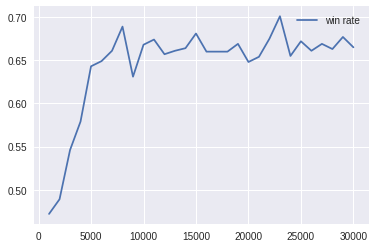

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.array(env.win_rate_history)[:, 0]
y = np.array(env.win_rate_history)[:, 1]
plt.plot(x, y, label="win rate")
plt.legend()
plt.show()